\begin{center}
Gabe Morris
\end{center}

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import sympy as sp

from eng_analysis import bol_stoer, jacobi

plt.style.use('../maroon_ipynb.mplstyle')

Package contents found [here](https://github.com/gabemorris12/eng_analysis)

\pagebreak
\tableofcontents
\pagebreak

\begin{center}
\begin{tabular}{ccc}
ME 8213 & Homework 5 & Gabe Morris \\
& & gnm54
\end{tabular}
\end{center}

# Problem 1

![Figure 1](f1.PNG)

A projectile of mass $m$ experiences a drag force $F_d=c\nu^2$ where $\nu$ is the magnitude of the velocity. The equations of motion in the x and y directions are:

$$\ddot{x}=-\frac{c}{m}\nu\dot{x}$$

$$\ddot{y}=-\frac{c}{m}\nu\dot{y}-g$$

If the projectile is to hit a target 8 $km$ away after flying for 10 seconds, determine the launch velocity $\nu_0$ and angle of inclination $\theta$. Use $m=20\,kg$, $c=3.2\times10^{-4}\,kg/m$, and $g=9.80665\,m/s^2$.

## Solution
We need to put the system in the state-variable form. In the math below, I am saying that $z_0=x$ and $z_1=y$.

In [2]:
# Symbols
t, m, c, g, = sp.symbols('t m c g')
z0, z1, z2, z3 = sp.Function('z0')(t), sp.Function('z1')(t), sp.Function('z2')(t), sp.Function('z3')(t)

# Constants
m_ = 20  # kg
c_ = 3.2e-4  # kg/m
g_ = 9.80665  # m/s^2

nu = sp.sqrt(z0.diff()**2 + z1.diff()**2)
eq1 = sp.Eq(z0.diff(t, 2), -c/m*nu*z0.diff())
eq2 = sp.Eq(z1.diff(t, 2), -c/m*nu*z1.diff() - g)
display(eq1, eq2)

Eq(Derivative(z0(t), (t, 2)), -c*sqrt(Derivative(z0(t), t)**2 + Derivative(z1(t), t)**2)*Derivative(z0(t), t)/m)

Eq(Derivative(z1(t), (t, 2)), -c*sqrt(Derivative(z0(t), t)**2 + Derivative(z1(t), t)**2)*Derivative(z1(t), t)/m - g)

In [3]:
eq3 = sp.Eq(z0.diff(), z2)
eq4 = sp.Eq(z1.diff(), z3)

sub_states = [
    (z0.diff(), z2),
    (z1.diff(), z3)
]

sol = sp.solve([eq1.subs(sub_states), eq2.subs(sub_states), eq3, eq4], [z0.diff(), z1.diff(), z2.diff(), z3.diff()],
               dict=True)[0]
for key, value in sol.items():
    display(sp.Eq(key, value))

Eq(Derivative(z0(t), t), z2(t))

Eq(Derivative(z1(t), t), z3(t))

Eq(Derivative(z2(t), t), -c*sqrt(z2(t)**2 + z3(t)**2)*z2(t)/m)

Eq(Derivative(z3(t), t), -c*sqrt(z2(t)**2 + z3(t)**2)*z3(t)/m - g)

The book has a different philosophy for applying the Runge-Kutta and Bulirsch-Stoer. The philosophy of packages like `scipy` may be used instead. The main difference is that `scipy` functions will take in an already defined, evenly spaced time array. The book goes about it by constructing this time array, but some might see this as unnecessary.

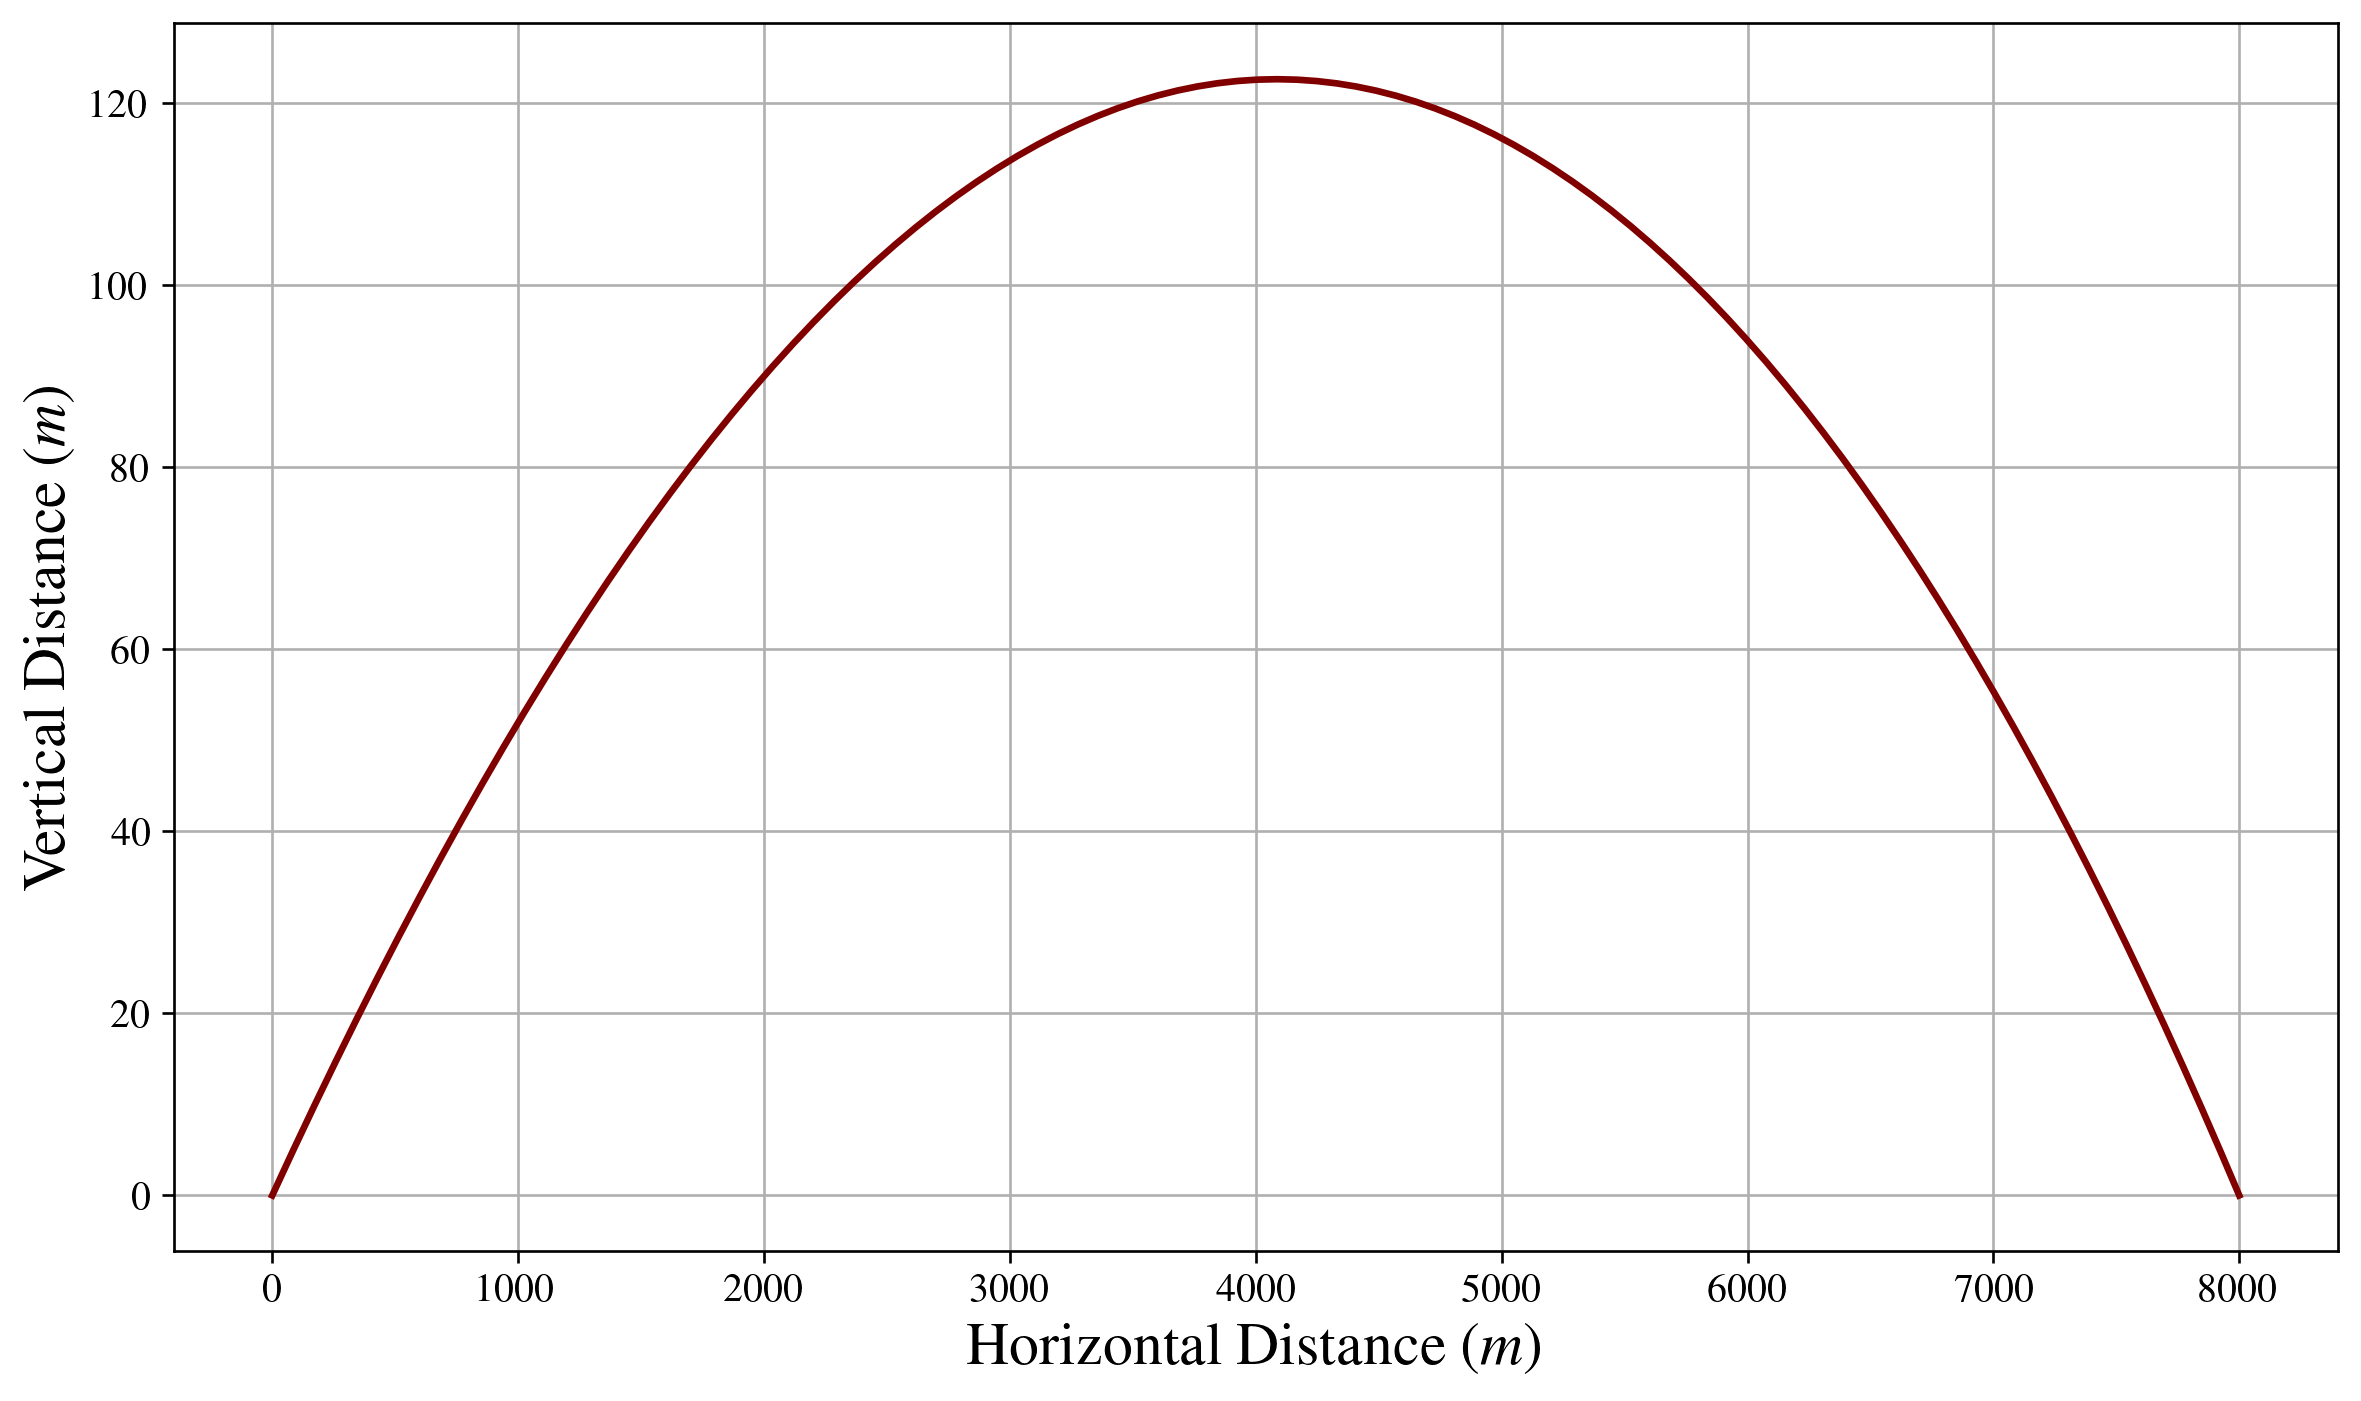

In [4]:
def state_vars(_, z):
    vel = np.sqrt(z[2]**2 + z[3]**2)
    return [
        z[2],
        z[3],
        -c_*vel*z[2]/m_,
        -c_*vel*z[3]/m_ - g_
    ]


def bcs(ya, yb):
    # z0(0) = 0, z0(10) = 8000, z1(0) = 0, z1(10) = 0
    return [
        ya[0],
        yb[0] - 8000,
        ya[1],
        yb[1]
    ]


t_array = np.linspace(0, 10, 100)
sol = bol_stoer(state_vars, bcs, t_array, np.zeros((4, t_array.size)))

plt.plot(sol[0], sol[1])
plt.xlabel('Horizontal Distance ($m$)')
plt.ylabel('Vertical Distance ($m$)')
plt.show()

I can tell that this must be a bullet projectile. This is the plot if the aspect ratio of the x and y-axis are equal:

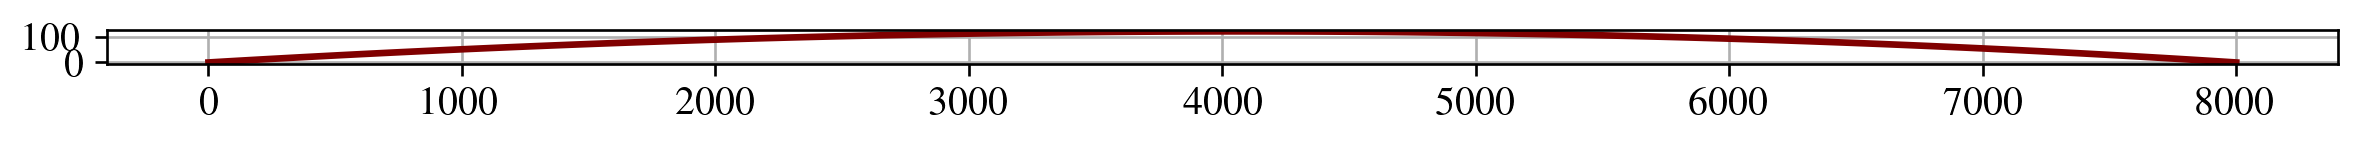

In [5]:
fig, ax = plt.subplots()
ax.plot(sol[0], sol[1])
ax.set_aspect('equal')
plt.show()

The initial velocity can be extracted from the solution where the magnitude and angle can be determined.

In [6]:
x_vel = sol[2][0]
y_vel = sol[3][0]
v0 = x_vel + 1j*y_vel
v0  # m/s (complex vector form)

(853.4897829271363+50.14976545163223j)

In [7]:
# Magnitude
np.abs(v0)  # m/s

854.961875486775

In [8]:
# Angle
np.rad2deg(np.angle(v0))  # degrees

3.36274665258457

\pagebreak

\begin{center}
\begin{tabular}{ccc}
ME 8213 & Homework 5 & Gabe Morris \\
& & gnm54
\end{tabular}
\end{center}

# Problem 2

![Figure 2](f2.PNG)

The differential equations for the system above are:

$$
\begin{gathered}
k(-2u_1+u_2)=m\ddot{u}_1 \\
k(u_1-2u_2+u_3)=3m\ddot{u}_2 \\
k(u_2-2u_3)=2m\ddot{u}_3
\end{gathered}
$$

where $u_i(t)$ is the displacement of mass $i$ from its equilibrium position and $k$ is the spring stiffness. Determine the frequencies of vibration and the corresponding mode shapes. Use $k=30\,N/m$ and $m=5\,kg$.

## Solution
We need to get the eigenvalues of the standard form $H$. This can be done by getting the system into the $Ax=\lambda Bx$ form, then applying equation 9.26b (if $B$ is diagonal). The book likes to do this by substituting $u_i=x_i\sin\omega t$, but I find it to be easier by converting to the laplace space.

In [9]:
# Making system of equations
t, s, k, m = sp.symbols('t s k m')
u1, u2, u3 = sp.Function('u1')(t), sp.Function('u2')(t), sp.Function('u3')(t)

eq1 = sp.Eq(m*u1.diff(t, 2), -k*u1 + k*(u2 - u1))
eq2 = sp.Eq(3*m*u2.diff(t, 2), k*(u1 - u2) + k*(u3 - u2))
eq3 = sp.Eq(2*m*u3.diff(t, 2), -k*u3 + k*(u2 - u3))

display(eq1, eq2, eq3)

Eq(m*Derivative(u1(t), (t, 2)), k*(-u1(t) + u2(t)) - k*u1(t))

Eq(3*m*Derivative(u2(t), (t, 2)), k*(u1(t) - u2(t)) + k*(-u2(t) + u3(t)))

Eq(2*m*Derivative(u3(t), (t, 2)), k*(u2(t) - u3(t)) - k*u3(t))

In [10]:
# Converting to the laplace space
def lp(expr): return sp.laplace_transform(expr, t, s)[0]


eq1_s = sp.Eq(lp(eq1.lhs), lp(eq1.rhs.expand()))
eq2_s = sp.Eq(lp(eq2.lhs), lp(eq2.rhs.expand()))
eq3_s = sp.Eq(lp(eq3.lhs), lp(eq3.rhs.expand()))

# Making initial conditions zero
sub_ics = [
    (u1.subs(t, 0), 0),
    (u1.diff().subs(t, 0), 0),
    (u2.subs(t, 0), 0),
    (u2.diff().subs(t, 0), 0),
    (u3.subs(t, 0), 0),
    (u3.diff().subs(t, 0), 0)
]

eq1_s = eq1_s.subs(sub_ics)
eq2_s = eq2_s.subs(sub_ics)
eq3_s = eq3_s.subs(sub_ics)

u = sp.Matrix([lp(u1), lp(u2), lp(u3)])

A_sys, b = sp.linear_eq_to_matrix([eq1_s, eq2_s, eq3_s], [lp(u1), lp(u2), lp(u3)])
sp.Eq(sp.MatMul(A_sys, u), b)

Eq(Matrix([
[2*k + m*s**2,             -k,              0],
[          -k, 2*k + 3*m*s**2,             -k],
[           0,             -k, 2*k + 2*m*s**2]])*Matrix([
[LaplaceTransform(u1(t), t, s)],
[LaplaceTransform(u2(t), t, s)],
[LaplaceTransform(u3(t), t, s)]]), Matrix([
[0],
[0],
[0]]))

The above is the matrix representation of our system in the laplace space. It can be seen that this matrix form can also take the following form:

$$
\underbrace{\left[\begin{array}{rrr}
2 & -1 & 0 \\
-1 & 2 & -1 \\
0 & -1 & 2
\end{array}\right]}_{A}\left[\begin{array}{l}
U_1(s) \\
U_2(s) \\
U_3(s)
\end{array}\right]=s^2 \underbrace{\frac{m}{k}\left[\begin{array}{lll}
1 & 0 & 0 \\
0 & 3 & 0 \\
0 & 0 & 2
\end{array}\right]}_{B}\left[\begin{array}{l}
U_1(s) \\
U_2(s) \\
U_3(s)
\end{array}\right]
$$

Now that it can be seen that $B$ is diagonal, the following is true:

$$
H_{i j}=\frac{A_{i j}}{\sqrt{\beta_i \beta_j}}
$$

In [11]:
m_ = 5  # kg
k_ = 30  # N/m

A = np.array([
    [2, -1, 0],
    [-1, 2, -1],
    [0, -1, 2]
], dtype=np.float64)

beta = m_/k_*np.array([1, 3, 2], dtype=np.float64)
H = [[A[i, j]/np.sqrt(beta[i]*beta[j]) for j in range(3)] for i in range(3)]

# Take the square root to recover
np.sqrt(jacobi(H)[0])

array([3.66026609, 1.23163671, 2.66186461])

The above natural frequencies are in $rad/s$.

Additionally, the solution may be checked by using the roots of the characteristic equation.

In [12]:
# Checking solution
poly = sp.det(A_sys)
poly_subs = poly.subs([
    (m, m_),
    (k, k_)
])
display(*sp.nroots(poly_subs))

-1.231636714333*I

1.231636714333*I

-2.66186460598293*I

2.66186460598293*I

-3.66026608640989*I

3.66026608640989*I

\pagebreak

\begin{center}
\begin{tabular}{ccc}
ME 8213 & Homework 5 & Gabe Morris \\
& & gnm54
\end{tabular}
\end{center}

# Problem 3

![Figure 3](f3.PNG)

Assume a long system of $n$ masses constrained to mode in the x-direction with mass $m$ with adjacent neighbors connected by springs of spring constant $k$. The normal modes and frequencies of this system can be found by finding the eigenvectors and eigenvalues of the mass-weighted Hessian matrix, whose elements are defined by:

$$
H_{i, j}^m=\frac{1}{\sqrt{m_i m_j}} \frac{\partial^2 E}{\partial x_i \partial x_j}
$$

where $E$ is the potential energy of the system and $x_i$ is the position of mass $i$. The eigenvalues of $H$ are proportional to the square of the mode frequency. Show how the frequency of the lowest and highest frequency modes change as $n$ increases and describe the shape of these modes. The potential energy of a spring is $\frac{1}{2}mx^2$. Use $k=1\,N/m$ and $m=1\,kg$.

## Solution
The potential energy of each spring is

$$E=\frac{1}{2}k(x_{i+1} - x_i)^2$$

Although, the first and last springs would be

$$
\begin{gathered}
E=\frac{1}{2}kx_1^2 \\
E=\frac{1}{2}kx_n^2
\end{gathered}
$$

The total energy is the sum of the above energy terms, and this expression is used to construct the Hessian matrix. The below cell contains the function that will get the hessian matrix as a function of $n$.

In [13]:
# Starting the index at zero for coordinates/masses
m, k = 1, 1

def get_H(n_):
    x = sp.symbols(f'x0:{n_}')
    
    half = sp.Rational(1, 2)
    E0 = half*k*x[0]**2
    En = half*k*x[-1]**2  # Really n - 1, but oh well
    Ei = sum([half*k*(x[i + 1] - x[i])**2 for i in range(n_ - 1)])
    E = sum([E0, Ei, En])
    H_ = []
    for i in range(n_):
        row = []
        for j in range(n_):
            f_j = E.diff(x[j])
            f_ij = f_j.diff(x[i])
            row.append(1/sp.sqrt(m*m)*f_ij)
        H_.append(row)
    return H_

H5 = sp.Matrix(get_H(5))
H5

Matrix([
[ 2, -1,  0,  0,  0],
[-1,  2, -1,  0,  0],
[ 0, -1,  2, -1,  0],
[ 0,  0, -1,  2, -1],
[ 0,  0,  0, -1,  2]])

In [14]:
# For n = 5
H5_ = np.float64(H5)
values, vectors = jacobi(H5_)
for val, vec in zip(values, vectors):
    print(f'{np.sqrt(val)}: {vec}')

1.9318516525781366: [ 0.28867513  0.28867513 -0.5         0.5         0.57735027]
0.5176380902050415: [-5.00000000e-01  5.00000000e-01 -5.00000000e-01 -5.00000000e-01
  8.26394164e-10]
1.0: [ 5.77350269e-01  5.77350269e-01 -8.65370963e-10  7.47062378e-14
 -5.77350269e-01]
1.7320508075688772: [-5.00000000e-01  5.00000000e-01  5.00000000e-01  5.00000000e-01
 -6.76720232e-10]
1.4142135623730951: [ 0.28867513  0.28867513  0.5        -0.5         0.57735027]


The above cell shows the modes ($rad/s$) and shape with 5 masses. The below cell will plot the maximum and minimum frequencies as a function of $n$. 

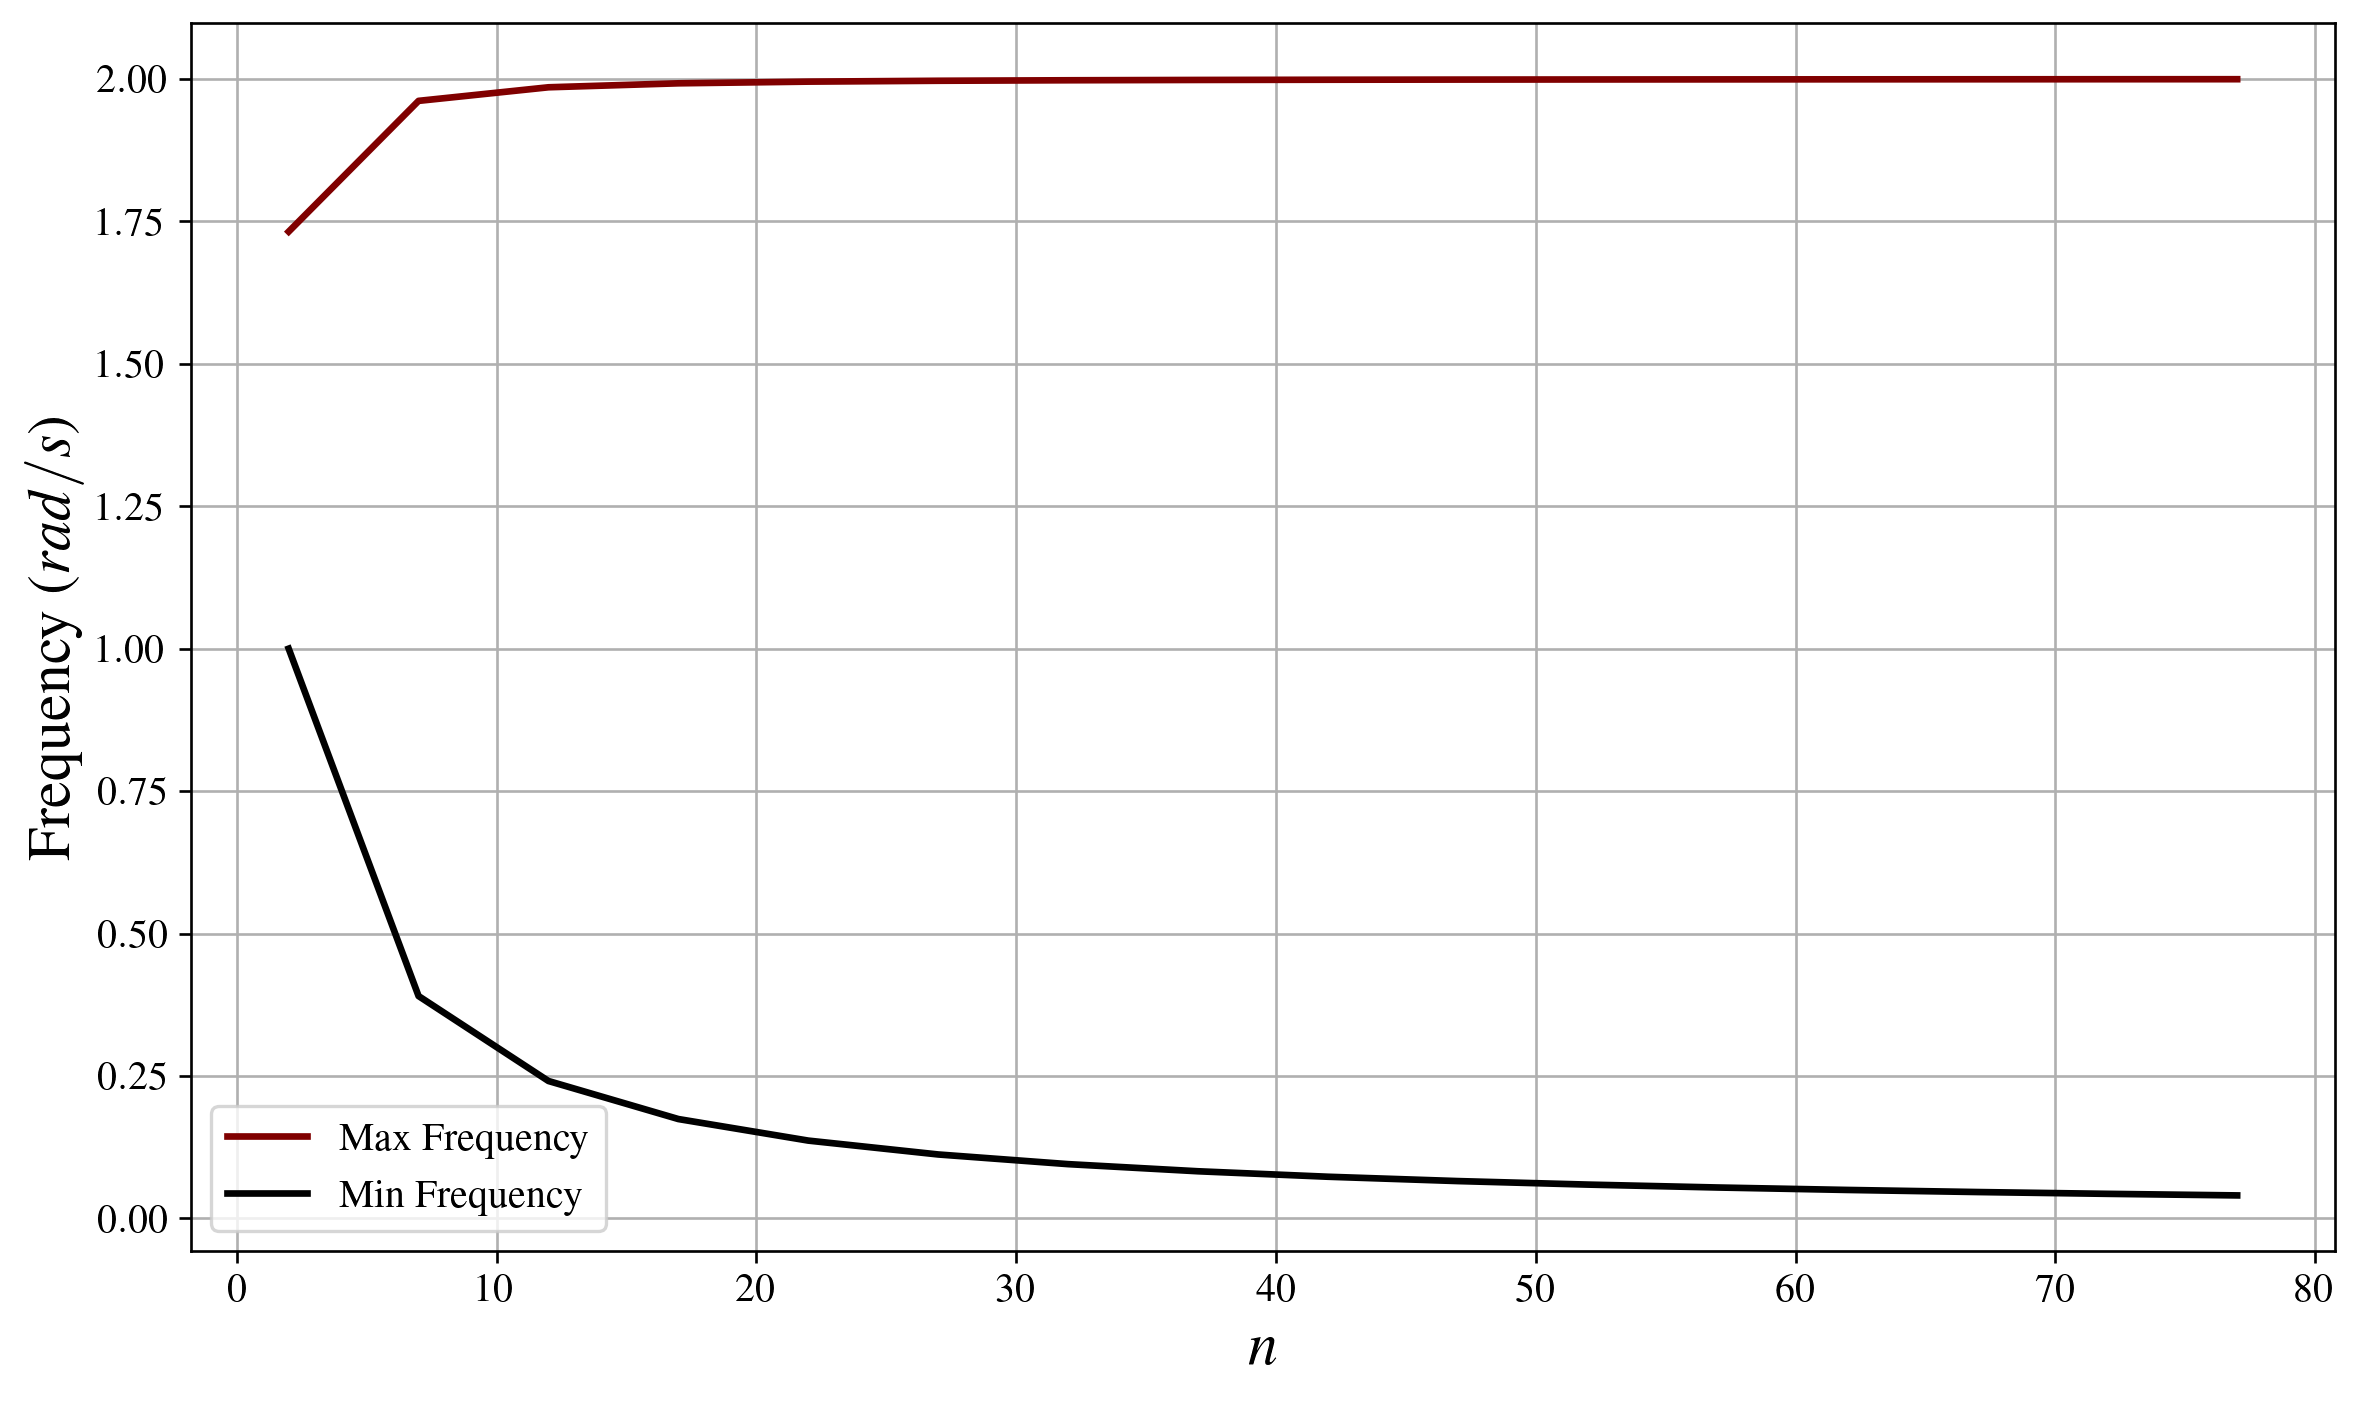

In [15]:
fig, ax = plt.subplots()
i = np.arange(2, 80, 5)

max_values, min_values = [], []
for n in i:
    Hess = np.float64(get_H(n))
    values, _ = jacobi(Hess)
    max_val = max(np.sqrt(values))
    min_val = min(np.sqrt(values))
    max_values.append(max_val)
    min_values.append(min_val)

ax.plot(i, max_values, label='Max Frequency')
ax.plot(i, min_values, label='Min Frequency')
ax.legend()
ax.set_ylabel('Frequency ($rad/s$)')
ax.set_xlabel('$n$')
plt.show()

The above results show that the maximum frequency approaches 2 $rad/s$, and the minimum frequency approaches a smaller values (close to zero) as the number of masses increases.

The shape can be tested and plotted for the $n=3$, $n=10$, $n=20$, etc. cases.

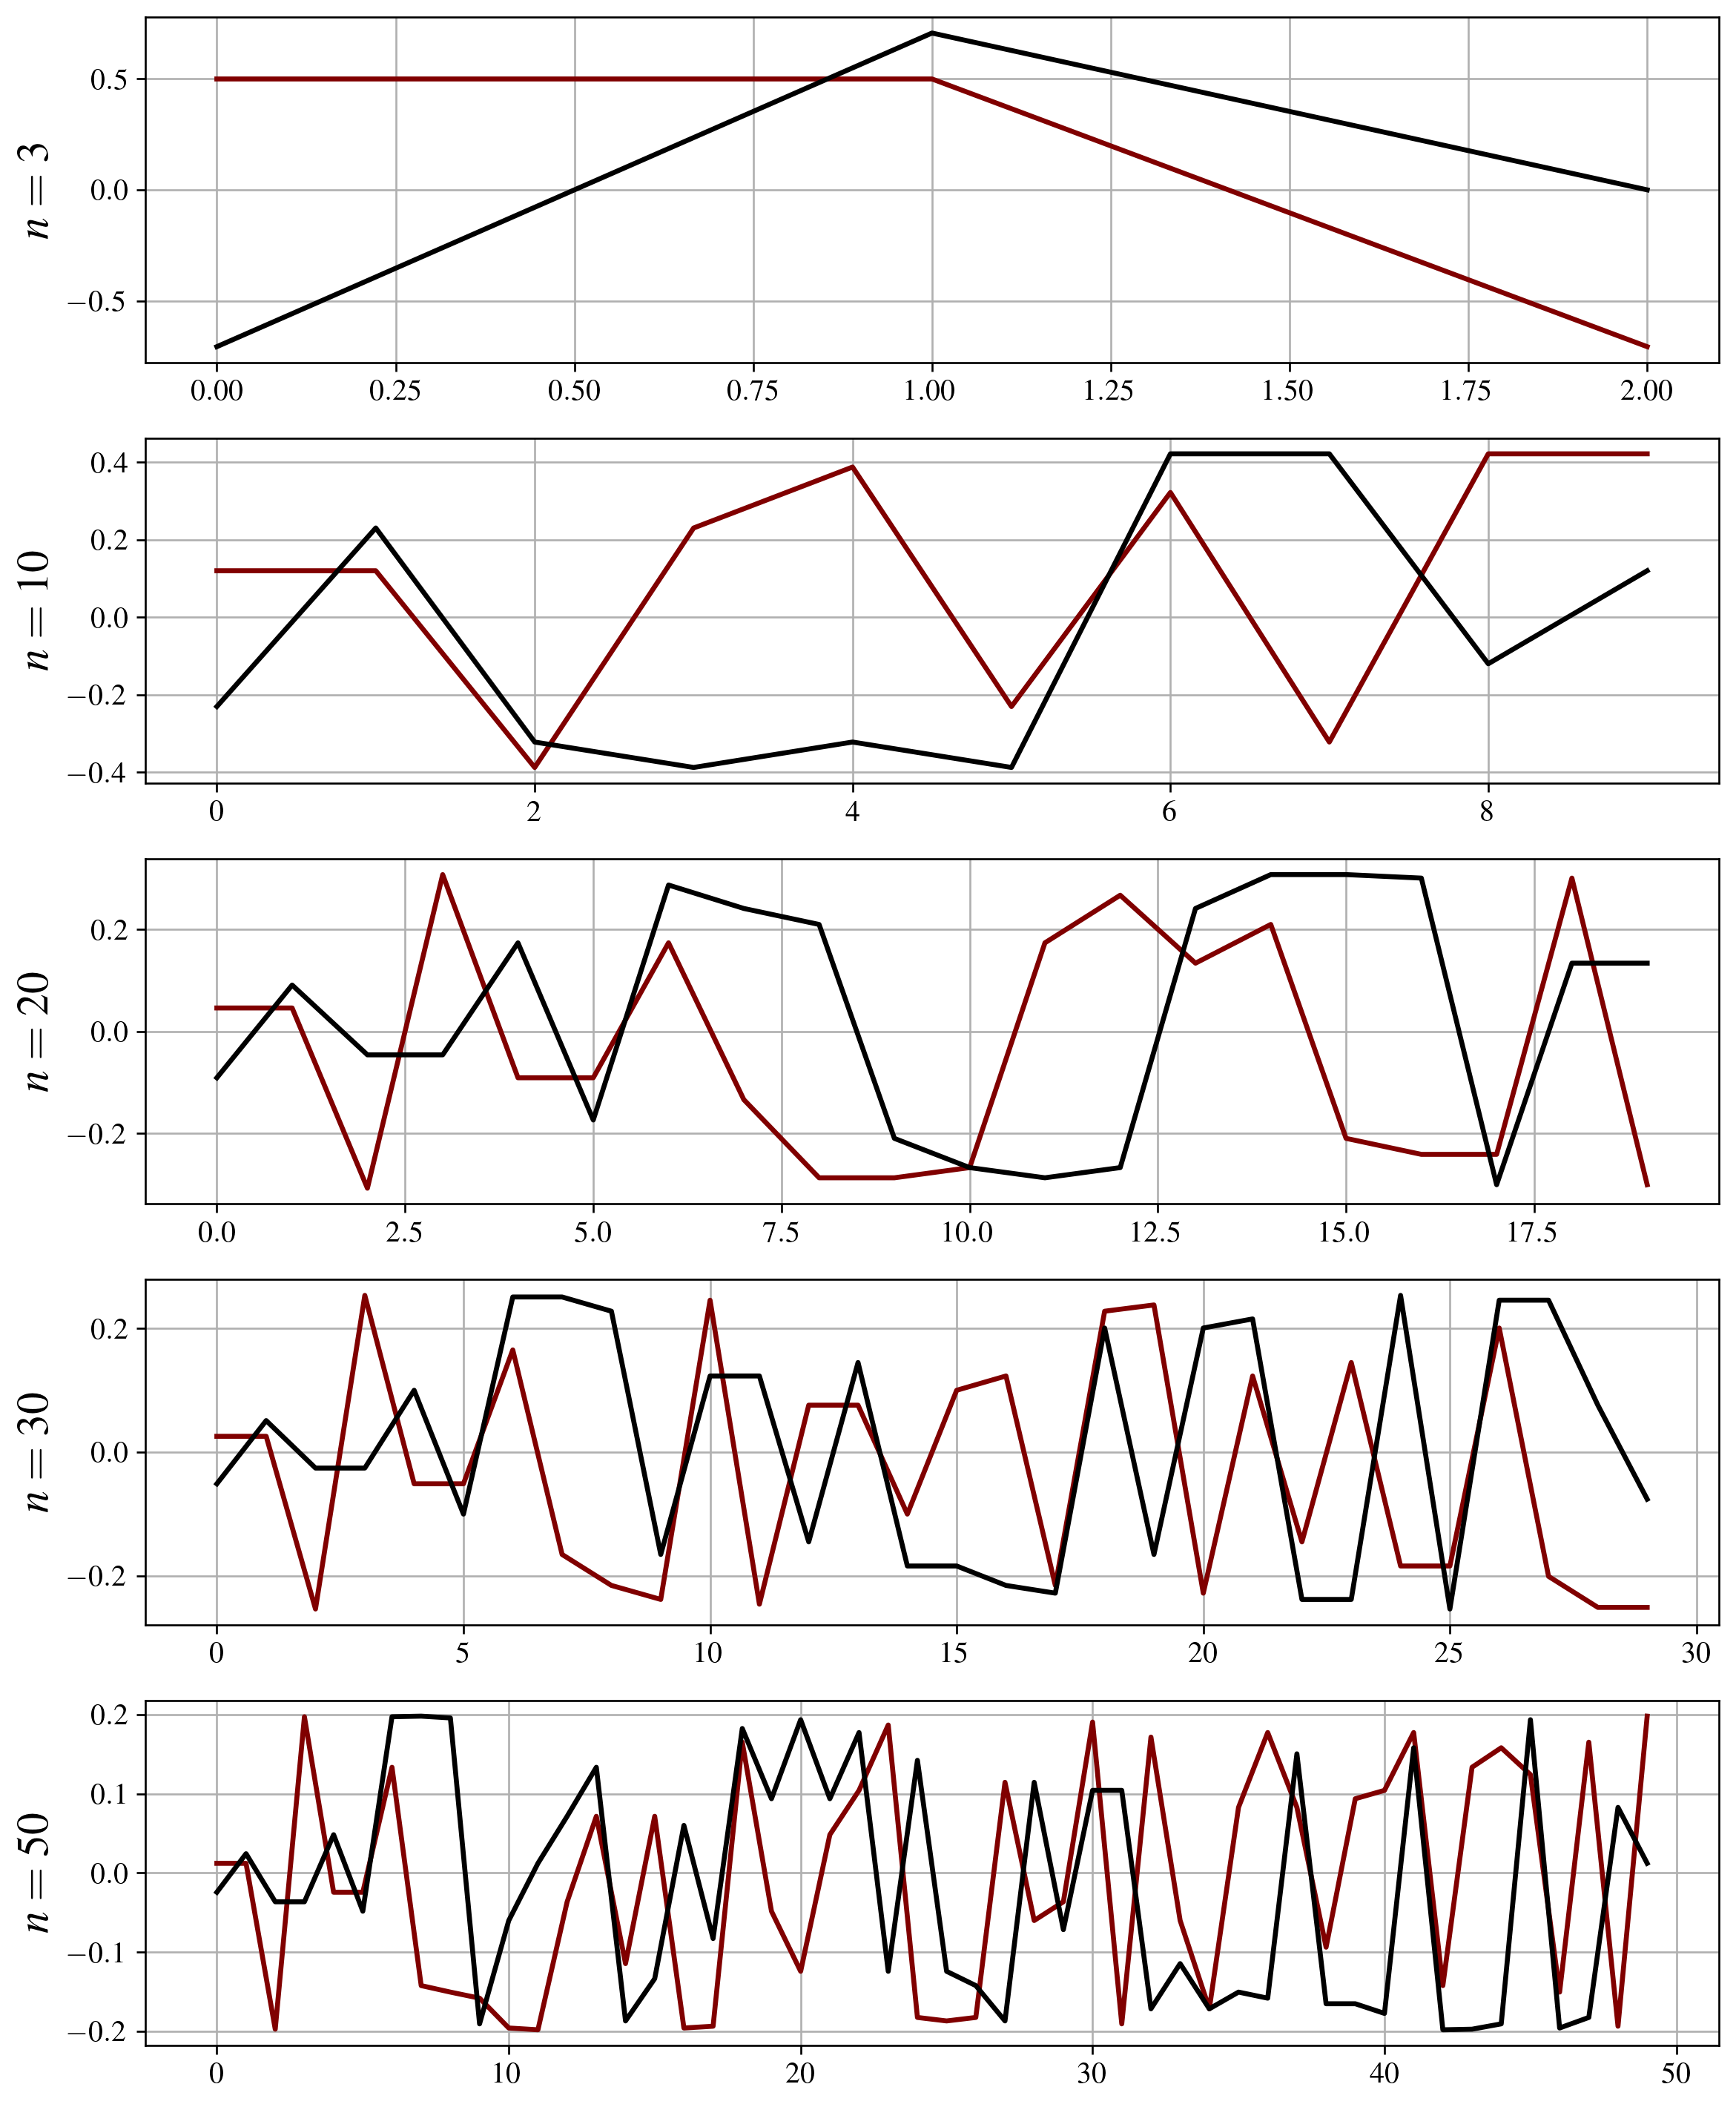

In [16]:
n_values = [3, 10, 20, 30, 50]
fig, ax = plt.subplots(nrows=len(n_values), ncols=1)
fig.set_figheight(12)

for i, n in enumerate(n_values):
    Hess = np.float64(get_H(n))
    values, vectors = jacobi(Hess)
    result = {val: vec for val, vec in zip(values, vectors)}
    ax[i].plot(list(range(n)), result[max(values)], label='Shape at Max Frequency')
    ax[i].plot(list(range(n)), result[min(values)], label='Shape at Min Frequency')
    ax[i].set_ylabel(f'$n={n}$')

plt.show()

The shape shows that as the number of masses increase, the effect that one mass has on the other gets smaller and approaches peak values of 0.2 for $n=50$, but the peaks are 0.5 for $n=3$. There is not one mass or area that consistently dominates the others.